In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440331  6.455077  6.391279  6.422877  493729600
2010-01-05  6.451465  6.487878  6.417459  6.458085  601904800
2010-01-06  6.348846  6.477045  6.342225  6.451465  552160000
2010-01-07  6.337110  6.379843  6.291067  6.372319  477131200
2010-01-08  6.379240  6.379842  6.291368  6.328683  447610800


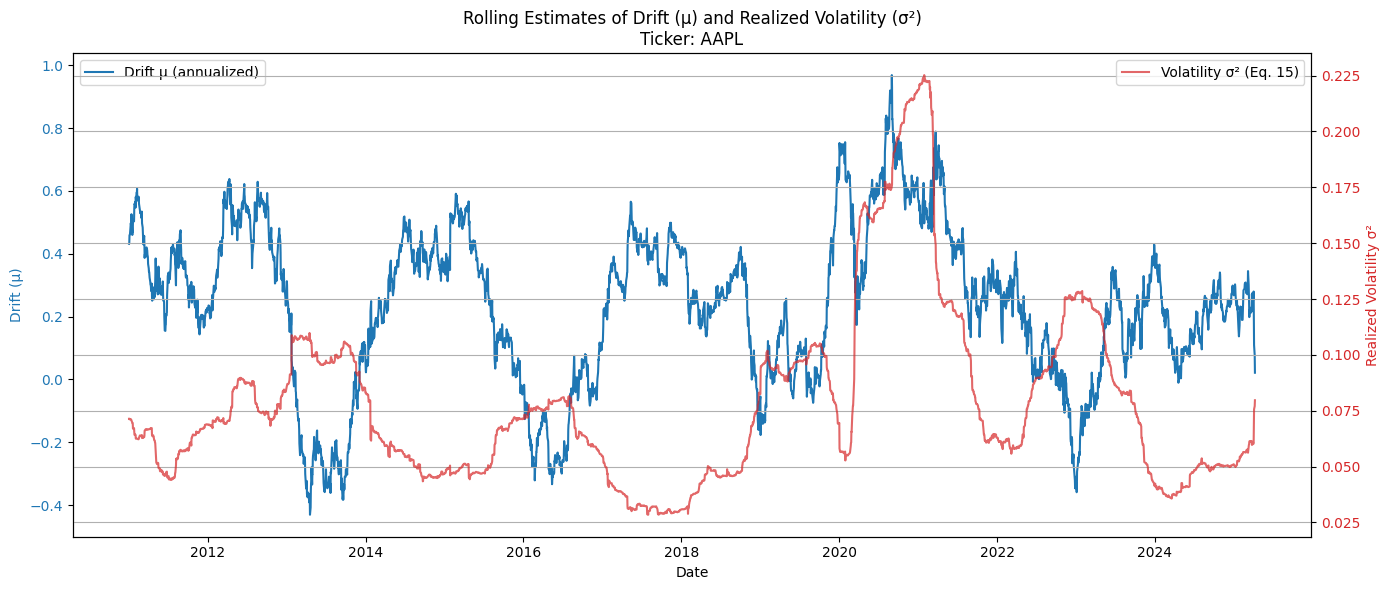

In [20]:
def sigma2_from_eq15(log_returns, N = 252, delta_t=1/252):
    """
    基于公式 (15) 估计年化 realized volatility
    参数:
        log_returns: 一段 log return 时间序列（pd.Series）
        delta_t: 时间步长，默认为日频 (1/252)
    返回:
        sigma2_hat: 实现波动率的无偏估计 σ²（年化）
    """
    if log_returns.isnull().any():
        return np.nan

    T = N * delta_t

    # μ̂_N 的估计
    mu_hat = log_returns.mean() / delta_t

    # 第一个求和项：Σ r_k^2
    sum_squared_returns = (log_returns ** 2).sum()

    # 最终波动率估计
    sigma2_hat = (1 / ((N - 1) * delta_t)) * sum_squared_returns - (T / (N - 1)) * mu_hat**2
    return sigma2_hat


ticker = 'AAPL'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date)
print(data.head())

N = 252 # Number of trading days in a year
delta_t = 1 / N # Time increment in years

data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
log_returns = data['LogReturn'].dropna().iloc[-N:]

data['RollingMu'] = data['LogReturn'].rolling(window=N).mean() / delta_t  # see equation (10) in the appendix
data['Sigma2_rolling'] = data['LogReturn'].rolling(window=N).apply(sigma2_from_eq15, args=(N, delta_t), raw=False)
data['Sigma_rolling'] = np.sqrt(data['Sigma2_rolling'])


# 开始绘图
fig, ax1 = plt.subplots(figsize=(14, 6))

# 第一条 Y 轴：画 μ (drift)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Drift (μ)', color=color)
ax1.plot(data.index, data['RollingMu'], color=color, label='Drift μ (annualized)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# 第二条 Y 轴：画 σ² (volatility)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Realized Volatility σ²', color=color)
ax2.plot(data.index, data['Sigma2_rolling'], color=color, label='Volatility σ² (Eq. 15)', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# 美化标题和布局
plt.title(f"Rolling Estimates of Drift (μ) and Realized Volatility (σ²)\nTicker: {ticker}")
fig.tight_layout()
plt.grid(True)
plt.show()
